In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import synapseclient as sc
sns.set_style("dark")

%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [50]:
entity = syn.get("syn21027479")
data   = pd.read_csv(entity["path"], index_col = 0).drop(["age", "gender", \
                                "recordId", "phoneInfo", "createdOn"], axis = 1)

In [60]:
def rename_column_name(data, agg):
    for feature in filter(lambda x: "sfm" in x, data.columns): 
        data  = data.rename({feature: "{}_{}"\
                            .format(agg, feature)}, axis = 1)
    return data

def plot_distribution(data):
    for i in [i for i in data.columns if "sfm" in i]:
        PD = data[data["PD"] == True][i].dropna()
        NONPD = data[data["PD"] == False][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "PD", y = i, data = data, ax = axes[1], orient = "v", order = [True, False])
        axes[0].set_title("p-values: {}".format(ttest_ind(PD, NONPD)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()

In [52]:
balance_median_data = rename_column_name(data.groupby("healthCode").median(), "med")
balance_mean_data = rename_column_name(data.groupby("healthCode").median(), "mean")
balance_max_data = rename_column_name(data.groupby("healthCode").median(), "max")
balance_min_data = rename_column_name(data.groupby("healthCode").median(), "min")

In [53]:
data = pd.concat([balance_median_data, balance_max_data, balance_mean_data, balance_min_data], axis = 1)
data = data.groupby(data.columns, axis=1).mean()

# Distribution Before Splitting

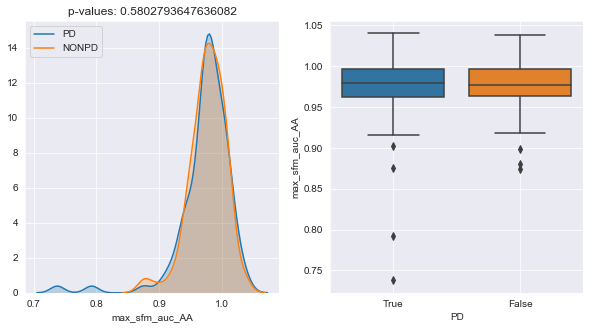

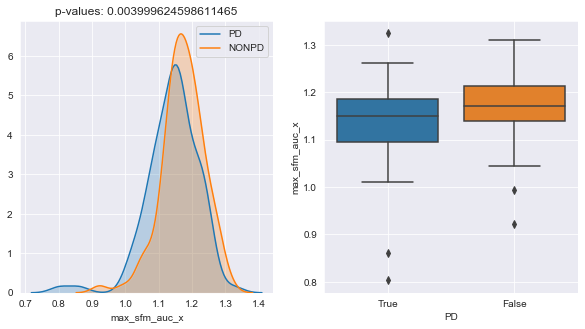

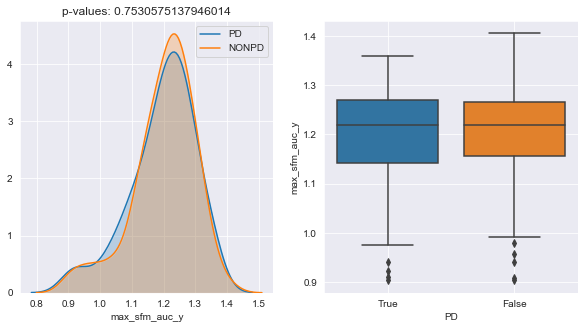

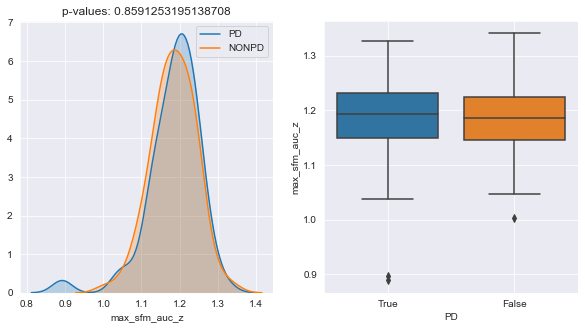

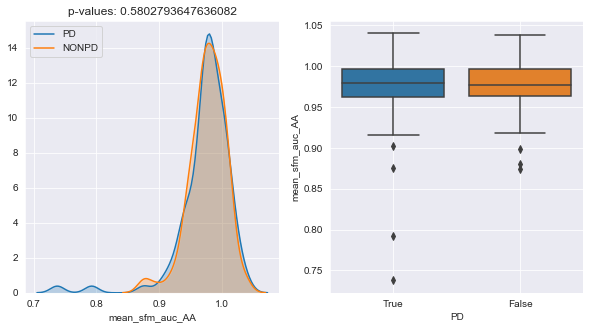

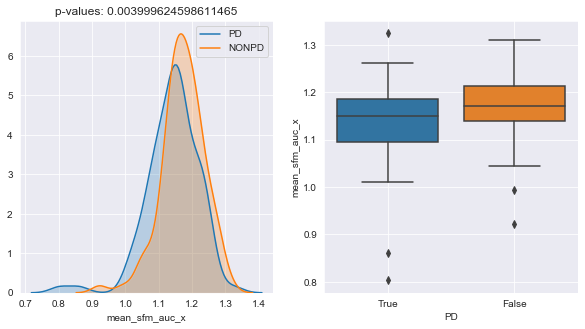

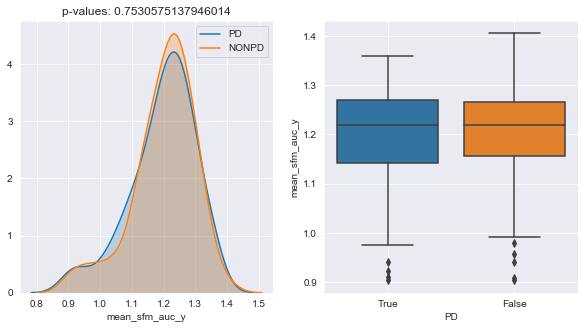

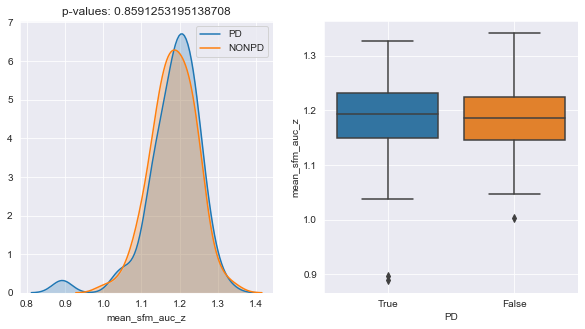

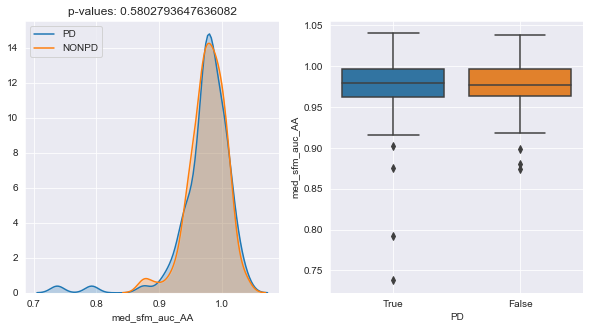

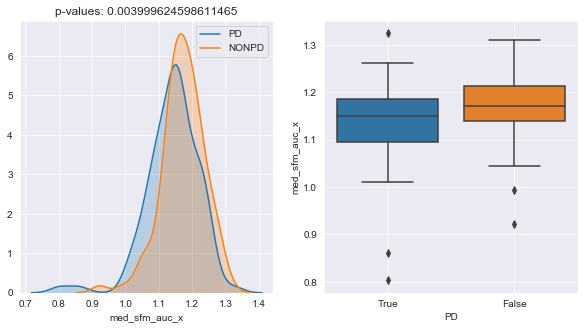

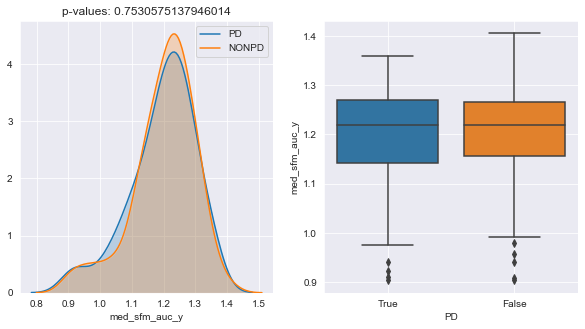

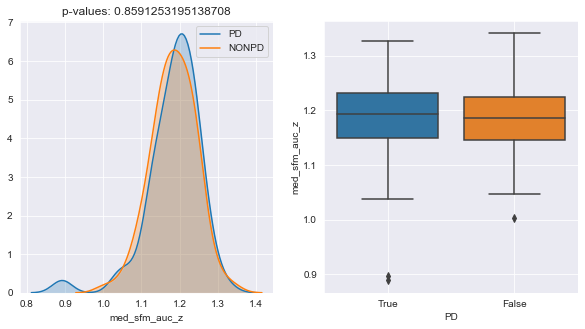

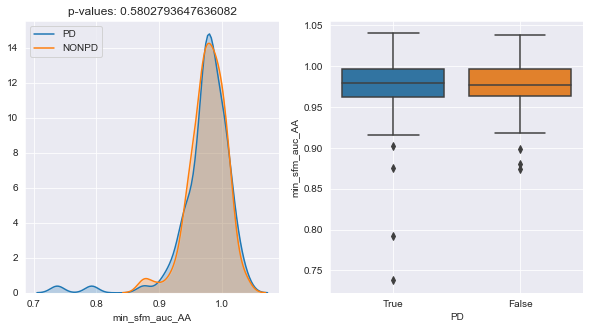

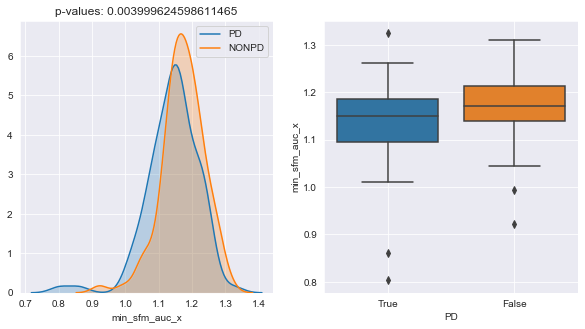

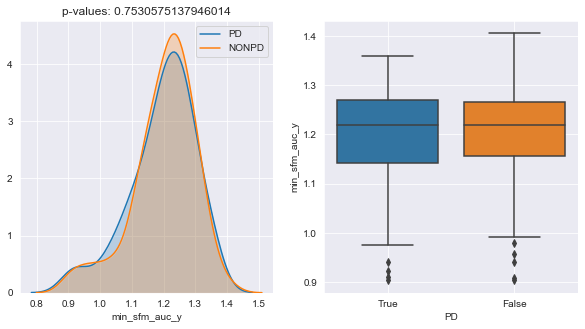

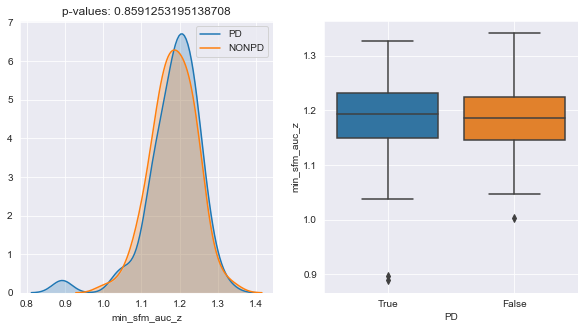

In [61]:
plot_distribution(data)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

In [64]:
balance_train = data.copy()
balance_X_train, balance_X_test, balance_y_train, balance_y_test = \
train_test_split(balance_train.drop(["PD"], axis = 1), 
                 balance_train["PD"], test_size=0.20, random_state = 100)

In [72]:
selector = SelectKBest(chi2, k=10).fit(balance_X_train, balance_y_train)
pd.Series(data = selector.scores_, index = balance_X_train.columns).sort_values(ascending = False)

min_sfm_auc_x      0.033884
med_sfm_auc_x      0.033884
mean_sfm_auc_x     0.033884
max_sfm_auc_x      0.033884
min_sfm_auc_z      0.001518
med_sfm_auc_z      0.001518
mean_sfm_auc_z     0.001518
max_sfm_auc_z      0.001518
min_sfm_auc_y      0.000110
med_sfm_auc_y      0.000110
mean_sfm_auc_y     0.000110
max_sfm_auc_y      0.000110
min_sfm_auc_AA     0.000033
med_sfm_auc_AA     0.000033
mean_sfm_auc_AA    0.000033
max_sfm_auc_AA     0.000033
dtype: float64

In [73]:
selected_columns = list(balance_X_train.columns[selector.get_support()])
new_columns = selected_columns + ["PD"]
data[new_columns].to_csv("../Data/BALANCE_TRAINING_DATA.csv")

In [74]:
list(balance_X_train.columns[selector.get_support()])

['max_sfm_auc_x',
 'max_sfm_auc_z',
 'mean_sfm_auc_x',
 'mean_sfm_auc_z',
 'med_sfm_auc_x',
 'med_sfm_auc_y',
 'med_sfm_auc_z',
 'min_sfm_auc_x',
 'min_sfm_auc_y',
 'min_sfm_auc_z']